### Import necessary libraries

In [240]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import ast
import prince

from sklearn.decomposition import PCA
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

### Data loading

In [269]:
data = pd.read_excel("data/set_corectat_complet.xlsx")

In [270]:
data

,date,region,phenomena,county,pm10_quality,air_pressure,temperature,humidity,water_average,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,2009-02-19,Banat,"['Ninsoare', 'Vant', 'Alunecare']",TM,51.630000,995.400000,-4.095000,85.500000,NaN,NaN,NaN,NaN,NaN
1,2009-02-19,Dobrogea,"['Ploaie', 'Lapovita', 'Vant', 'Ninsoare', 'In...",CT,21.520000,1005.875000,6.745000,96.750000,NaN,NaN,NaN,NaN,NaN
2,2009-02-19,Moldova,"['Ninsoare', 'Ger', 'Ploaie', 'Lapovita', 'Van...",IS,44.600000,1010.700000,-0.935000,99.000000,NaN,NaN,NaN,NaN,NaN
3,2009-02-19,Muntenia,"['Ninsoare', 'Lapovita', 'Ploaie', 'Vant', 'In...",B,34.428571,998.880000,0.252000,86.200000,NaN,NaN,NaN,NaN,NaN
4,2009-02-19,Oltenia,"['Ploaie', 'Lapovita', 'Ninsoare', 'Vant']",DJ,13.265000,NaN,0.760000,97.000000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25856,2023-08-19,Dobrogea,['Canicula'],CT,NaN,1011.633333,25.700000,73.000000,300.5,NaN,NaN,NaN,NaN
25857,2023-08-19,Moldova,['Canicula'],IS,NaN,1011.700000,25.250000,63.000000,300.5,NaN,NaN,NaN,NaN
25858,2023-08-19,Muntenia,['Canicula'],B,NaN,1005.350000,28.533750,43.428571,300.5,NaN,NaN,NaN,NaN
25859,2023-08-19,Transilvania,"['Grindina', 'Furtună']",CJ,NaN,979.800000,25.473333,65.333333,300.5,NaN,NaN,NaN,NaN


In [251]:
data['phenomena'] = data['phenomena'].apply(ast.literal_eval)

In [252]:
# Drop the specified columns and keep the specified ones
selected_columns = ['date', 'region', 'phenomena', 'county',
                    'pm10_quality', 
                    'air_pressure', 
                    'temperature', 
                    'humidity']

data_selected = data[selected_columns]

# Drop rows with missing values
data_selected_cleaned = data_selected.dropna()

### Elbow Method to determine the number of clusters

In [253]:
data_exploded = data_selected_cleaned.copy()
data_exploded = data_exploded.explode('phenomena')

In [254]:
data_exploded = data_exploded.dropna()

1
2
3
4
5
6
7
8
9
10


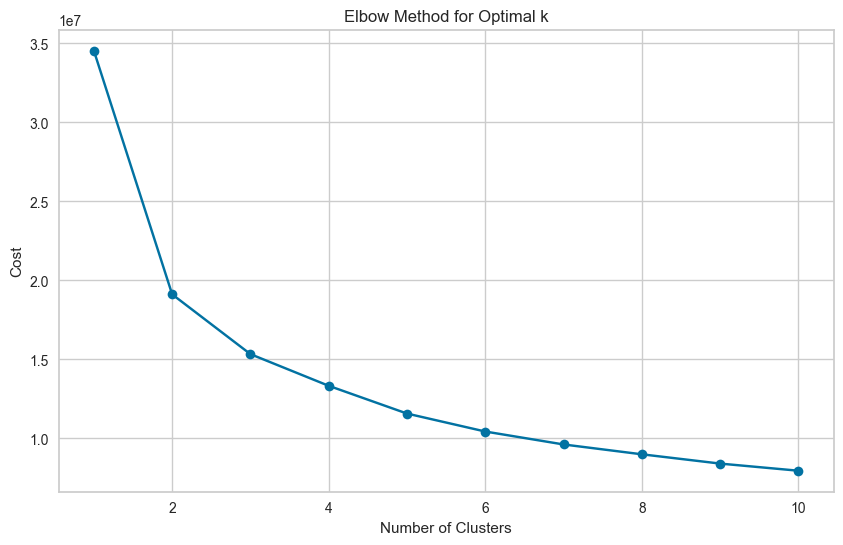

In [212]:
sample_data = data_exploded.sample(frac=0.5, random_state=42).drop(columns=['date', 'county', 'region'])

costs = []
K = range(1, 11)

for k in K:
    print(k)
    kproto = KPrototypes(n_clusters=k, init='Cao', verbose=0, n_jobs=-1)
    kproto.fit_predict(sample_data, categorical=[0])
    costs.append(kproto.cost_)

plt.figure(figsize=(10, 6))
plt.plot(K, costs, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [255]:
optimal_clusters = 4 
kproto = KPrototypes(n_clusters=optimal_clusters, init='Cao', verbose=0, n_jobs=-1)
clusters = kproto.fit_predict(data_exploded.drop(columns=['date','county', 'region']), categorical=[0])

In [256]:
data_exploded['Cluster'] = clusters

#### Value counts of every cluster

In [257]:
cluster_sizes = pd.Series(clusters).value_counts().sort_index()
cluster_sizes

0    18107
1     3692
2    11801
3    19248
Name: count, dtype: int64

### Central Tendency


In [259]:
# data_selected_cleaned['Cluster'] = clusters

# Central Tendency
numerical_cols = ['pm10_quality', 'air_pressure', 
                  'temperature', 'humidity']
categorical_cols = ['region', 'phenomena', 'county']

# Mean for numerical attributes
cluster_means = data_exploded.groupby('Cluster')[numerical_cols].mean()

# Mode for categorical attributes
cluster_modes = data_exploded.groupby('Cluster')[categorical_cols].agg(lambda x: x.value_counts().index[0])

central_tendency = pd.concat([cluster_means, cluster_modes], axis=1)

central_tendency

,pm10_quality,air_pressure,temperature,humidity,region,phenomena,county
Cluster,,,,,,,
0,25.877987,1000.561474,19.379233,60.312748,Muntenia,Ploaie,B
1,58.838718,1001.062241,5.267200,79.366014,Moldova,Ploaie,IS
2,22.799157,946.353084,11.541019,77.467443,Transilvania,Ninsoare,BV
3,21.267176,1006.406908,10.211532,85.691185,Dobrogea,Ploaie,CT


#### Standard deviation within each cluster

In [260]:
# Standard deviation for numerical attributes
cluster_std_dev = data_exploded.groupby('Cluster')[numerical_cols].std()
cluster_std_dev

,pm10_quality,air_pressure,temperature,humidity
Cluster,,,,
0,9.092336,11.911031,7.329197,10.396889
1,20.731821,15.564939,9.240676,11.886470
2,11.518107,17.012609,8.720623,12.025494
3,7.914856,14.816220,8.498127,8.212302


### Study the top 10 phenomena among each cluster

In [261]:
def get_season(date):
    """Return the season for a given date."""
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# data_selected_cleaned['Cluster'] = clusters

# Extracting the season
data_exploded['Season'] = data_exploded['date'].apply(get_season)

In [262]:
# Recreate the phenomena_counts variable without further manipulation of 'phenomena'
# phenomena_exploded = data_selected_cleaned.explode('phenomena')
phenomena_counts = data_exploded.groupby(['Season', 'Cluster'])['phenomena'].value_counts().unstack(level=-1).fillna(0)

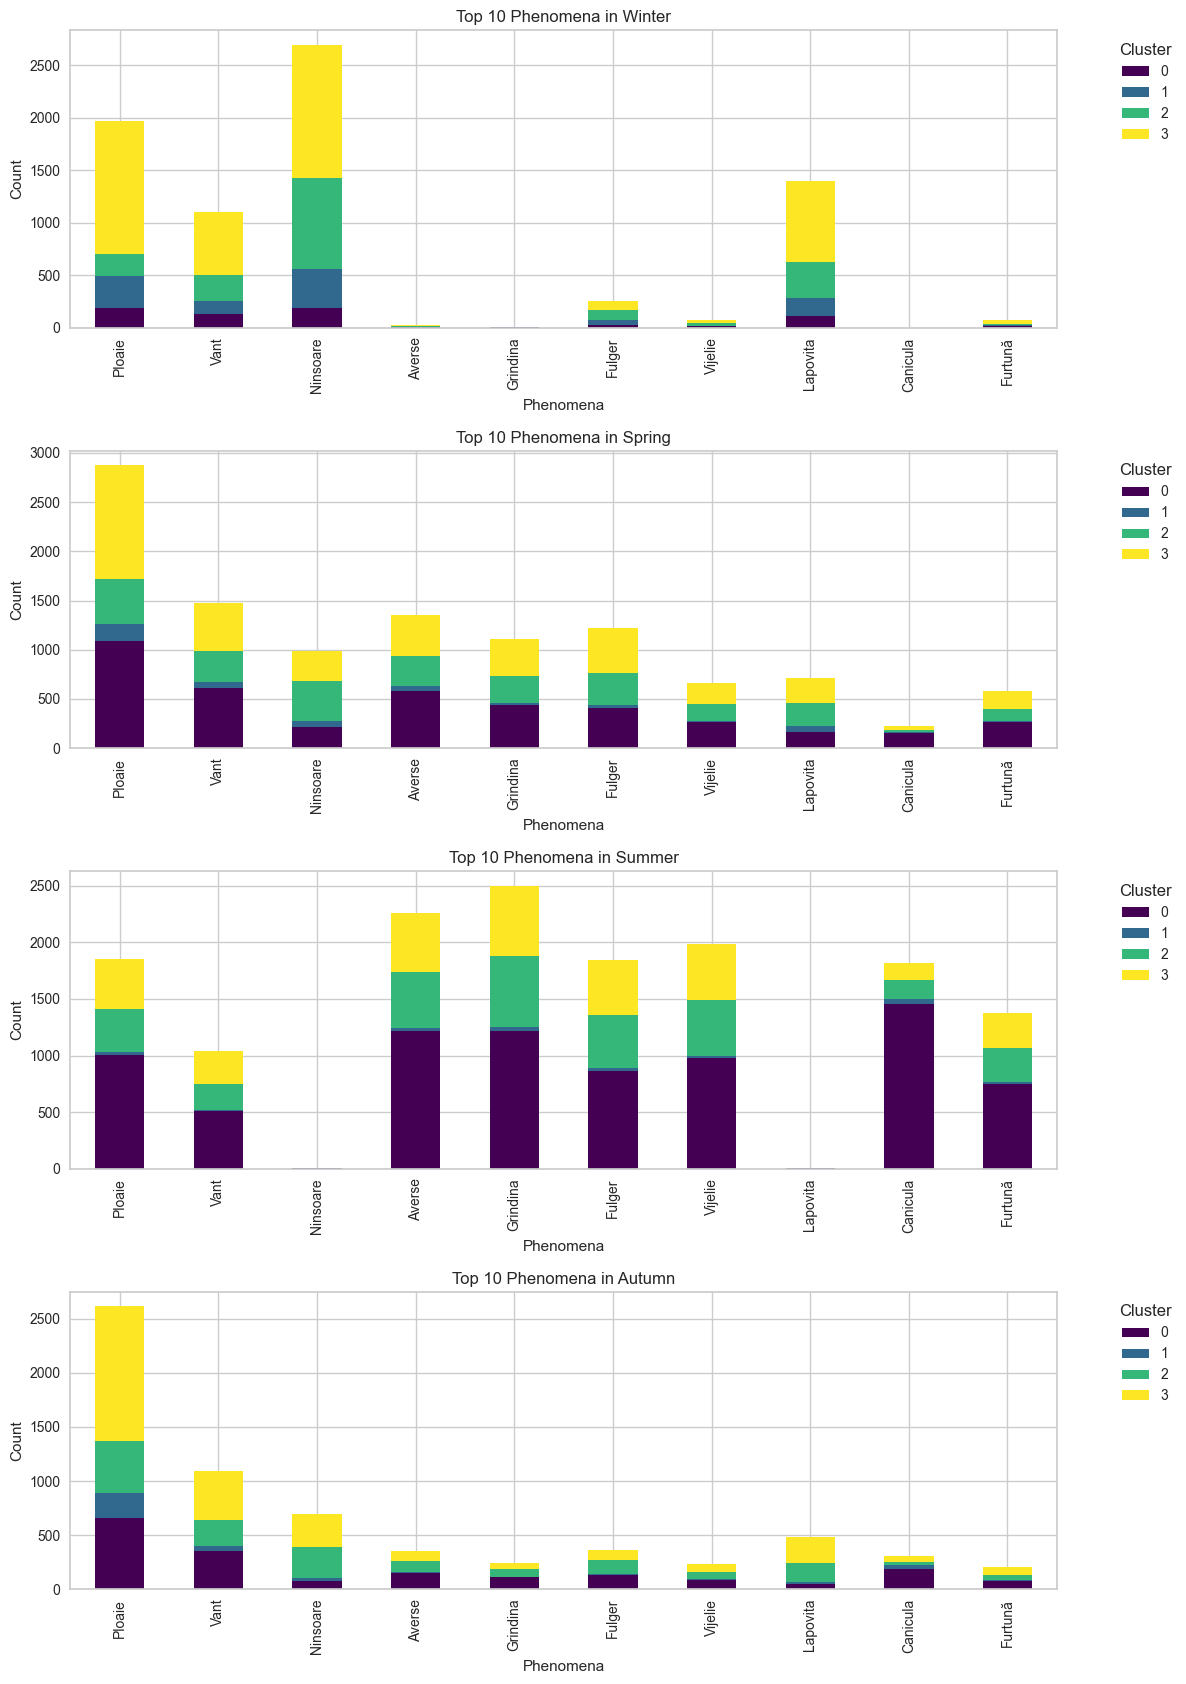

In [263]:
# Identify the top 10 phenomena based on their overall occurrence
top_10_phenomena = phenomena_counts.sum(axis=0).sort_values(ascending=False).head(10).index

# Extract the data for the top 10 phenomena
top_phenomena_data = phenomena_counts[top_10_phenomena]

# Visualizing the top 10 phenomena for each season and cluster
fig, axes = plt.subplots(nrows=4, figsize=(12, 17))

for idx, season in enumerate(seasons):
    ax = axes[idx]
    
    # Extracting data for the current season
    seasonal_data = top_phenomena_data.loc[season]
    
    # Plotting
    seasonal_data.T.plot(kind='bar', stacked=True, ax=ax, colormap='viridis')
    ax.set_title(f'Top 10 Phenomena in {season}')
    ax.set_ylabel('Count')
    ax.set_xlabel('Phenomena')
    ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### Descriptive statistics for every cluster

In [265]:
# Group by cluster and compute descriptive statistics
cluster_descriptive_stats = data_exploded.groupby('Cluster').agg({
    'pm10_quality': ['mean', 'median', 'max', 'min'],
    'air_pressure': ['mean', 'median', 'max', 'min'],
    'temperature': ['mean', 'median', 'max', 'min'],
    'humidity': ['mean', 'median', 'max', 'min']
})
cluster_descriptive_stats

pm10_quality                                 air_pressure  \
                mean     median         max      min         mean   
Cluster                                                             
0          25.877987  24.937500   63.500000   0.9700  1000.561474   
1          58.838718  52.696667  230.285714  35.7425  1001.062241   
2          22.799157  20.806667   88.075000   1.4500   946.353084   
3          21.267176  20.471000   48.855000   2.1000  1006.406908   

                                      temperature                      \
              median      max     min        mean     median      max   
Cluster                                                                 
0        1001.850000  1099.80  964.60   19.379233  21.482000  34.3775   
1        1003.400000  1059.35  930.54    5.267200   4.380000  30.1600   
2         946.466667   976.50  805.70   11.541019  12.320000  34.0350   
3        1005.100000  1100.00  974.30   10.211532   9.533333  38.9325   

                     humidity                               
               min       mean     median    max        min  
Cluster                                                     
0       -14.205000  60.312748  61.857143   82.0   6.000000  
1       -19.123333  79.366014  80.333333  100.0  24.666667  
2       -17.650000  77.467443  78.000000  100.0  28.166667  
3       -16.333333  85.691185  85.500000  100.0  51.000000